In [1]:
from matplotlib import pyplot as plt 
import networkx as nx 

In [3]:
# Read the gml file
G = nx.read_gml('../data/graph/LEMD_EGLL_2023_04_01.gml')
print('Route graph read. {} nodes and {} edges'.format(G.number_of_nodes(), G.number_of_edges()))

Route graph read. 221 nodes and 1182 edges


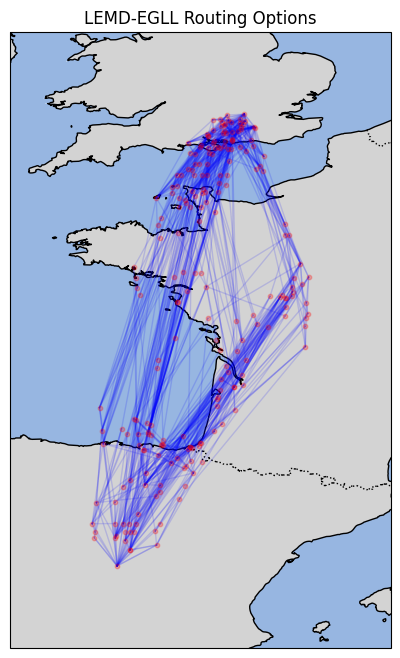

In [4]:
def plot_route_graph(G):
    import cartopy.crs as ccrs
    import cartopy.feature as cfeature

    # Extract node positions
    node_lats = []
    node_lons = []
    for n, data in G.nodes(data=True):
        node_lats.append(float(data['lat']))
        node_lons.append(float(data['lon']))

    # Set up the map
    fig = plt.figure(figsize=(10, 8))
    ax = plt.axes(projection=ccrs.PlateCarree())
    ax.set_global()
    ax.coastlines()
    ax.add_feature(cfeature.BORDERS, linestyle=':')
    ax.add_feature(cfeature.LAND, facecolor='lightgray')
    ax.add_feature(cfeature.OCEAN)

    # Plot edges
    for u, v in G.edges():
        lat1 = float(G.nodes[u]['lat'])
        lon1 = float(G.nodes[u]['lon'])
        lat2 = float(G.nodes[v]['lat'])
        lon2 = float(G.nodes[v]['lon'])
        ax.plot([lon1, lon2], [lat1, lat2], color='blue', linewidth=1, alpha=0.15, transform=ccrs.PlateCarree())

    # Plot nodes
    ax.scatter(node_lons, node_lats, color='red', s=10, zorder=5, transform=ccrs.PlateCarree(), alpha=0.25)

    # Optionally, set extent to fit the route
    margin = 2
    min_lon, max_lon = min(node_lons), max(node_lons)
    min_lat, max_lat = min(node_lats), max(node_lats)
    ax.set_extent([min_lon - margin, max_lon + margin, min_lat - margin, max_lat + margin], crs=ccrs.PlateCarree())

    plt.title("LEMD-EGLL Routing Options")
    plt.show()

plot_route_graph(G)